# Mapping ice flow velocity using an easy and interactive feature tracking workflow

## Authors

- Author1 = {"name": "Whyjay Zheng",      "affiliation": "University of California Berkeley",      "email": "whyjz@berkeley.edu", "orcid": "0000-0002-2316-2614"}
- Author2 = {"name": "Shane Grigsby",     "affiliation": "University of Maryland / NASA Goddard Center", "email": "grigsby@umd.edu", "orcid": "0000-0003-4904-7785"}
- Author3 = {"name": "Facundo Sapienza",  "affiliation": "University of California Berkeley",      "email": "fsapienza@berkeley.edu", "orcid": "orcid"}
- Author4 = {"name": "Jonathan Taylor",   "affiliation": "Stanford University",         "email": "jonathan.taylor@stanford.edu", "orcid": "0000-0002-1716-7160"}
- Author5 = {"name": "Tasha Snow",        "affiliation": "Colorado School of Mines",            "email": "tsnow@mines.edu", "orcid": "0000-0001-5697-5470"}
- Author6 = {"name": "Fernando Pérez",    "affiliation": "University of California Berkeley",      "email": "fernando.perez@berkeley.edu", "orcid": "0000-0002-1725-9815"}
- Author7 = {"name": "Matthew Siegfried", "affiliation": "Colorado School of Mines",            "email": "siegfried@mines.edu", "orcid": "orcid"}

## Purpose

Observations of ice flow velocity provide a key component for modeling glacier dynamics and mass balance. The feature tracking technique is one of the most commonly used methods for deriving ice flow velocity from remote sensing data. Despite being cost-effective compared to field measurements, running a feature tracking workflow is not easy because 1) searching for good data can be time-consuming; 2) fetching data can be challenging because the source images often come in a large size; and, 3) there is no standardized workflow for performing feature tracking. 

Here we present an interactive, notebook-based interface that deploys the entire feature tracking workflow. This open-source tool aims to provide users an easy way to perform glacier feature tracking. 

## Technical contributions

- We develop a fully customizable workflow for mapping glacier velocities using the feature tracking technique.
- We develop two Python libraries, GeoStacks and EZTrack, for general spatial and domain-specific processes respectively.
- We build an Jupyter interface that users and aggregate the feature tracking algorithm of their choice and interactively view the ice flow mapping results.

## Methodology

The modularizes workflow consists of the following steps: 

1. query data 
2. retrieve and aggregate data into system memory 
3. select feature tracking kernel and parameters
4. filter data for feature enhancement
5. perform feature tracking 
6. mask outliers and interpolate results as needed 
7. visualize and export results

Each step is fully customizable and extensible. We use the GeoStacks package for the first two steps. For this demo notebook, we use feature tracking processes from the CARST software (Cryosphere And Remote Sensing Toolkit, see References).

## Results

In our demo notebook, we query data over Jakobshavn Isbræ, a large outlet glacier of the Greenland Ice Sheet with a history of seasonal flow speed variation (Khazendar et al., 2019). Users can choose to explore the ITS_LIVE velocity dataset or the Landsat 8 imagery and perform feature tracking for the latter. As mentioned above, the feature tracking kernel and all related filters, masks, and interpolation processes are from CARST, but users can easily replace any of them or the entire package with their algorithms or a different feature tracking package (e.g., autoRIFT; Lei et al., 2021). The modules used by this demo notebook, including the GeoStacks and CARST packages, are open-source software and welcome community contributions. The demo notebook represents a way to integrate the entire feature tracking application. Users can also access the same modular content from the tools we use and adopt them in their own projects. 

This new tool provides a way for researchers to explore new data, compare different algorithms, and validate their results. It also shows a full potential on education uses since it lowers the technical threshold for manipulating satellite data and deriving glacier speeds. 

## Funding

- Award1 = {"agency": "US National Science Foundation", "award_code": "1928406", "award_URL": "https://nsf.gov/awardsearch/showAward?AWD_ID=1928406" }
- Award2 = {"agency": "US National Science Foundation", "award_code": "1928374", "award_URL": "https://nsf.gov/awardsearch/showAward?AWD_ID=1928374" }


## Keywords

keywords=["glacier velocity", "feature tracking", "ice flow", "remote sensing", "ITS_LIVE"]

## Citation

Zheng, W., Grisby, S., Sapienza, F., Taylor, J., Snow, T., Pérez, F., & Siegfried, M. (2021). Mapping ice flow velocity using an easy and interactive feature tracking workflow. Accessed x/x/xxxx at https://github.com/whyjz/EZ-FeatureTrack


<!-- ## Work In Progress - improvements 
Use this section only if the notebook is not final.

Notable TODOs:
- todo 1;
- todo 2;
- todo 3.

Notable TODOs:
- develop similar template for R, and possibly other languages [7]; -->

## Suggested next steps

Future integration of this work with a numerical glacier model or a web-based service is also possible.

<!-- ## Acknowledgements 

Include any relevant acknowledgements, apart from funding (which was in section 1.6)

This notebook template extends the original notebook template provided with the jupytemplate extension [5]. It is a result of collaboration between the TAC Working Group and the EarthCube Office. 

The template is licensed under a <a href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License.</a> -->

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

First, we import 
1. GeoStacks - providing processes for accessing spatial data and their metadata. Here we have two classes: `SpatialIndexLS8` for Landsat 8, `SpatialIndexITSLIVE` for the ITS_LIVE dataset.
2. EZTrack - UI, feature tracking core, and some related processes (e.g., spatial filters, data storage, etc.)

In [2]:
import os
os.environ['GDAL_SKIP'] = 'DODS'

from geostacks import SpatialIndexLS8, SpatialIndexITSLIVE
from eztrack import eztrack_ui

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


# Read LS8 spatial indices 

To start, we need to use the LS8 corner points for the spatial extent for each path/row combination. Input data from https://www.usgs.gov/media/files/landsat-wrs-2-corner-points

In [3]:
ls8_index = SpatialIndexLS8('./LS8_cornerPts.xlsx')
ls8_index.read()
ls8_index.footprint

,path,row,lat_CTR,lon_CTR,geometry
0,1,1,80.774791,3.210620,"POLYGON ((5.42400 81.92300, 9.94700 80.30700, ..."
1,1,2,80.021757,-4.274059,"POLYGON ((-3.20700 81.20300, 2.30700 79.69900,..."
2,1,3,79.129883,-10.647337,"POLYGON ((-10.43200 80.32200, -4.40400 78.9360..."
3,1,4,78.130377,-16.029408,"POLYGON ((-16.40900 79.32000, -10.20700 78.048..."
4,1,5,77.048078,-20.572231,"POLYGON ((-21.35100 78.22700, -15.19300 77.061..."
...,...,...,...,...,...
57778,233,244,81.352691,28.155956,"POLYGON ((35.64600 81.84800, 30.97900 80.24500..."
57779,233,245,81.718750,18.566867,"POLYGON ((25.77700 82.38700, 22.59000 80.69100..."
57780,233,246,81.844418,8.404287,"POLYGON ((14.79400 82.68000, 13.57600 80.92900..."
57781,233,247,81.718750,-1.758293,"POLYGON ((3.34700 82.69600, 4.31400 80.94200, ..."


The `SpatialIndexLS8` class comes with a `query_pathrow` method that uses quad tree and point-in-polygon spatial algorithms. It queries all Path/Row combinations that cover a query point.

In [4]:
query_pt = [-50., 69.]
idxs = ls8_index.query_pathrow(query_pt)
ls8_index.footprint.loc[idxs]

,path,row,lat_CTR,lon_CTR,geometry
1747,8,12,68.279631,-49.545762,"POLYGON ((-50.91000 69.35600, -46.41400 68.660..."
1994,9,11,69.606373,-49.402408,"POLYGON ((-50.77700 70.69500, -46.05000 69.955..."
2242,10,11,69.606373,-50.947472,"POLYGON ((-52.32200 70.69500, -47.59500 69.955..."
20071,81,233,69.606373,-48.123782,"POLYGON ((-44.88600 69.19800, -49.35900 68.507..."
20319,82,233,69.606373,-49.668847,"POLYGON ((-46.43100 69.19800, -50.90400 68.507..."
20566,83,232,68.279631,-49.525493,"POLYGON ((-46.50100 67.84400, -50.76100 67.192..."
20567,83,233,69.606373,-51.213911,"POLYGON ((-47.97600 69.19800, -52.44900 68.507..."
20814,84,232,68.279631,-51.070557,"POLYGON ((-48.04600 67.84400, -52.30600 67.192..."


# The Feature Tracking UI

With information from a `SpatialIndex` object, we build up a UI that allows users to query Landsat 8 and ITS_LIVE data.

In [5]:
cpanel = eztrack_ui(spatial_index=ls8_index)
cpanel.gen_ui()

AppLayout(children=(VBox(children=(HTML(value='<h2>Drag the marker to your region of interest</h2>'), Select(d…

Feature tracking results or the selected ITS_LIVE data are stored in `cpanel.results` once the `run` button is clicked. The data structure of `cpanel.results` depends on the data/kernel selection:

- ITS_LIVE: `xarray` object
- CARST: `rasterio` dataset

In [6]:
cpanel.results

You can also view messages or errors generated by the UI during the feature tracking processes by accessing `cpanel.output`. For ITS_LIVE, this will let you get the URL if you want to download the selected scenes. For CARST, you can check the messages generated from each feature tracking steps.

In [7]:
cpanel.output 

# Sample comparison between the ITS_LIVE data set and feature tracking results from a customized workflow

Using the UI and the workflow provided here, we can easily select a satellite image pair, perform feature tracking using a customized workflow, and compare with results from a different workflow (e.g., ITS_LIVE).

The data show the summer speed of Jakobshavn Isbræ and some nearby glaciers in summer 2018. Note that ITS_LIVE and CARST results use a different projection.

Text(0.5, 1.0, 'CARST 20180612 - 20180730 \n Input: Landsat 8 Band 4 \n Chip size: 64 pixels \n Raw NCC kernel ouput, no outlier mask and hole interpolation \n Original LS8 scene extent')

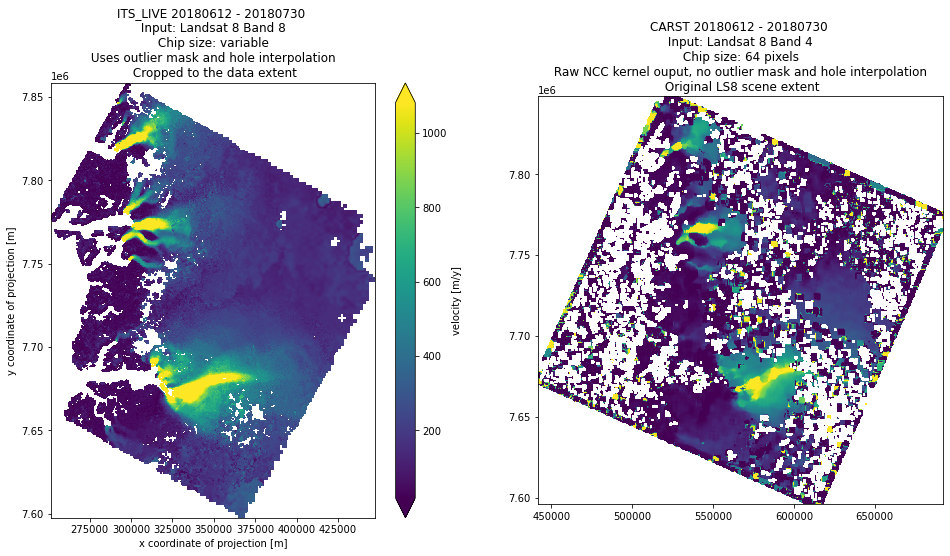

In [8]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import xarray as xr

# We use previously saved results for this demo, but you can also make this plot using the data in cpanel.results after running a feature tracking workflow.
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
result_itslive = xr.open_dataset('../data/LC08_L1TP_009011_20180730_20180814_01_T1_X_LC08_L1TP_009011_20180612_20180615_01_T1_G0240V01_P086.nc')
result_itslive.v.plot(ax=axes[0], robust=True, cmap=plt.cm.viridis)

result_carst = rasterio.open('../data/20180612-20180730_velo-raw_mag.tif')
show(result_carst, ax=axes[1], clim=[3.4, 6.3], cmap='viridis_r')

axes[0].set_title('ITS_LIVE 20180612 - 20180730 \n Input: Landsat 8 Band 8 \n Chip size: variable \n Uses outlier mask and hole interpolation \n Cropped to the data extent')
axes[1].set_title('CARST 20180612 - 20180730 \n Input: Landsat 8 Band 4 \n Chip size: 64 pixels \n Raw NCC kernel ouput, no outlier mask and hole interpolation \n Original LS8 scene extent')